## 剪枝算法尝试

In [1]:
import numpy as np
import sys
import time

import os
import cv2
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
sys.path.append('../')
sys.path.append('../data/')
from resnet import resnet
from preact_resnet import PreActResNet18
from load_cifar import load_cifar
from load_olivetti import load_olivetti

In [2]:
os.listdir('ckpts/')

['cifar_cap_res5_0.1_model.ckpt',
 'cifar_cap_preact_resnet_0.1_model.ckpt',
 '.ipynb_checkpoints',
 'olivetti_cap_resnet_1_model.ckpt',
 'olivetti_cap_preact_1_model.ckpt']

In [3]:
# 函数们
def rbg_to_grayscale(images):
    return np.dot(images[..., :3], [0.299, 0.587, 0.114])

def reshape_data(X_train, y_train, X_test):
    # reshape train and subtract mean
    pixel_mean = np.mean(X_train, axis=0)
    X_train -= pixel_mean
    X_test -= pixel_mean
    return X_train, y_train, X_test

def image_metrics(img1, img2):
    # return mean abs error and cosine distance
    img1 = img1.astype(float).flatten()
    img2 = img2.astype(float).flatten()
    return np.mean(np.abs(img1 - img2)),  np.abs(np.dot(img1, img2) / (np.linalg.norm(img1) * np.linalg.norm(img2)))

def normalize(x):
    x_shape = x.shape
    x = x.flatten()
    x_min = np.min(x)
    x_max = np.max(x)
    x = (x - x_min) / (x_max - x_min)
    return x.reshape(x_shape)

def iterate_minibatches(inputs, targets, batch_size):
    assert len(inputs) == len(targets)
    start_idx = None
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = slice(start_idx, start_idx + batch_size)
        yield inputs[excerpt], targets[excerpt]

    if start_idx is not None and start_idx + batch_size < len(inputs):
        excerpt = slice(start_idx + batch_size, len(inputs))
        yield inputs[excerpt], targets[excerpt]
        
def load_data(name='cifar'):
    if name == 'cifar':
        X_train, y_train, X_test, y_test = load_cifar(10)
        X_train = np.dstack((X_train[:, :1024], X_train[:, 1024:2048], X_train[:, 2048:]))
        X_train = X_train.reshape((-1, 32, 32, 3)).transpose(0, 3, 1, 2)
        X_test = np.dstack((X_test[:, :1024], X_test[:, 1024:2048], X_test[:, 2048:]))
        X_test = X_test.reshape((-1, 32, 32, 3)).transpose(0, 3, 1, 2)
    else:
        X_train, y_train, X_test, y_test = load_olivetti()
    return X_train, y_train, X_test, y_test

In [4]:
def data_to_loader(x, y, size=512):
    x_data = torch.from_numpy(x)
    y_data = torch.from_numpy(y).long()
    loader = DataLoader(dataset=TensorDataset(x_data, y_data), 
                          batch_size=size, 
                          shuffle=False, 
                          num_workers=2)
    return loader

#### 加载数据，构造恶意数据

In [5]:
def mal_data_synthesis(train_x, num_targets=10, precision=4):
    # synthesize malicious images to encode secrets
    # for CIFAR, use 2 data points to encode one approximate 4-bit pixel
    # thus divide the number of targets by 2
    num_targets //= 2
    if num_targets == 0:
        num_targets = 1

    targets = train_x[:num_targets]
    input_shape = train_x.shape
    if input_shape[1] == 3:  # rbg to gray scale
        targets = rbg_to_grayscale(targets.transpose(0, 2, 3, 1))

    mal_x = []
    mal_y = []
    for j in range(num_targets):
        target = targets[j].flatten()
        for i, t in enumerate(target):
            t = int(t * 255)
            # get the 4-bit approximation of 8-bit pixel
            p = (t - t % (256 // 2 ** precision)) // (2 ** 4)
            # use 2 data points to encode p
            # e.g. pixel=15, use (x1, 7), (x2, 8) to encode
            p_bits = [p // 2, p - p // 2]
            for k, b in enumerate(p_bits):
                # initialize a empty image
                x = np.zeros(input_shape[1:]).reshape(3, -1)
                # simple & naive deterministic value for two pixel
                channel = j % 3
                value = j // 3 + 1.0
                x[channel, i] = value
                if i < len(target) - 1:
                    x[channel, i + 1] = k + 1.0
                else:
                    x[channel, 0] = k + 1.0

                mal_x.append(x)
                mal_y.append(b)

    mal_x = np.asarray(mal_x, dtype=np.float32)
    mal_y = np.asarray(mal_y, dtype=np.int32)
    shape = [-1] + list(input_shape[1:])
    mal_x = mal_x.reshape(shape)
    return mal_x, mal_y, num_targets


In [6]:
# param_values = torch.load(MODEL_DIR+'cifar/resnet/cifar_cap_res5_0.1_model.ckpt')
param_values = torch.load('ckpts/cifar_cap_preact_resnet_0.1_model.ckpt')

X_train, y_train, X_test, y_test = load_data(name='cifar')
X_mal, y_mal, mal_n = mal_data_synthesis(X_train, num_targets=8)
X_train, y_train, X_test = reshape_data(X_train, y_train, X_test)
train_loader = data_to_loader(X_train, y_train)
test_loader = data_to_loader(X_test, y_test)
mal_loader = data_to_loader(X_mal, y_mal)

network = PreActResNet18(num_classes=10)
network.load_state_dict(param_values)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

#### 隐藏层抽取

In [7]:
out_list = []
network.to('cuda')
network.eval()
with torch.no_grad():
    for i, batch in enumerate(mal_loader):
        inputs, _ = batch
        outs = network.inner(inputs.to('cuda')).cpu().data.numpy()
        out_list.extend(list(outs))
np_out_list = np.array(out_list)
print(np_out_list.shape)

(8192, 512)


In [8]:
means = np_out_list.mean(axis=0)
seq_sort_mal = np.argsort(means)
seq_sort_mal

array([388, 314, 233, 247, 413,  60,  15, 195,  75, 309, 305, 312, 371,
       205, 366, 369, 479, 155, 469, 223, 132,  72, 297, 347, 346, 501,
       174, 146, 321, 243, 252, 378,  44, 127, 188,   0,  32,  54, 429,
       291,  39, 145, 351,  22, 203, 335, 459,   7,   8,  61,   3, 392,
       329,  79, 337, 356, 425, 222, 375, 410, 431, 477, 231,   4, 176,
       179, 447, 324, 343, 444, 144, 134, 165, 164, 380, 391, 331, 386,
        27, 348,  47, 241,  92, 204, 402,  40, 106, 354, 411,  96,  25,
       483, 102, 213,  93, 296,  26, 251, 139,  78, 446, 440, 399, 316,
       422, 123, 506, 157, 317, 323, 118, 401, 292, 288, 374, 238, 302,
        66, 187, 267, 472, 290, 114,  12,  19, 322, 385, 178,  31, 107,
       510, 172, 480, 409, 133, 342, 382, 221, 486, 283, 362, 494, 365,
       156, 168, 201, 142, 457, 148, 284, 225, 217, 481, 415, 357, 359,
        10, 460, 454,   1, 344,  82, 108, 159,  24, 272, 432, 268,  73,
       487, 327, 240, 498, 266, 261, 158,  35, 407, 262, 334, 27

In [9]:
np_clean_list = []
with torch.no_grad():
    for i,batch in enumerate(train_loader):
        inputs, _ = batch
        outs = network.inner(inputs.to('cuda')).cpu().data.numpy()
        np_clean_list.extend(list(outs))
np_clean_list = np.array(np_clean_list)
print(np_clean_list.shape)

(50000, 512)


In [10]:
cl_means = np_clean_list.mean(axis=0)
seq_sort_clean = np.argsort(cl_means)
seq_sort_clean

array([404, 281, 499,   5, 250, 490, 127, 368, 476, 336,  86, 264, 211,
       150, 146, 325, 179, 319, 399, 299,  84, 265, 128, 332, 162, 449,
       406,  62, 362, 111,  57, 214, 387, 138,  26, 400, 394, 330, 122,
       272, 326, 271, 242, 306, 263,   9,  83,   7, 229, 452,  41, 355,
       192, 282, 287, 274, 455, 276,  80, 277, 124,  67, 246,  69,  45,
       191, 143, 149, 433, 376, 202, 432, 403, 295, 241, 182, 486,  81,
        53,  59, 509, 311, 293, 460, 113,  98, 121, 103, 105, 443, 341,
        23, 481, 247, 283, 125, 417, 135, 412, 157, 500, 189, 482, 163,
       386, 506, 290, 456, 478, 142, 100, 428, 310, 303, 158,  51, 385,
        40, 260, 424, 308, 382, 462, 350, 230, 494, 347, 353,  93, 220,
       358, 427, 278, 209,  39, 497,  27, 235, 291, 331, 342, 302, 363,
       115, 430,   1, 300, 473, 167, 444, 488, 389,  30, 101,  42, 339,
        49,  31, 169,  55, 126,  89, 458, 317, 219, 116, 409, 454, 423,
       279, 175, 201, 365, 388,  79, 318, 335, 320, 360, 398, 22

In [11]:
neroun_num = 512

In [12]:
stat = []
mal = seq_sort_mal[::-1]
clean = seq_sort_clean[::-1]
print(" & ".join([str(x) for i,x in enumerate(mal) if (i+1) % 4 == 0]))
print(" & ".join([str(x) for i,x in enumerate(clean) if (i+1) % 4 == 0]))
for i in range(neroun_num):
    a = list(clean[:(i+1)])
    b = list(mal[:(i+1)])
    a.reverse()
    b.reverse()
    ab = a
    ab.extend(b)
    rest = 2*(i+1)-len(set(ab))
    stat.append(rest)


492 & 336 & 69 & 122 & 421 & 269 & 95 & 229 & 333 & 236 & 377 & 86 & 430 & 264 & 476 & 218 & 20 & 372 & 414 & 387 & 28 & 353 & 63 & 419 & 116 & 274 & 141 & 198 & 315 & 273 & 55 & 140 & 192 & 125 & 230 & 338 & 6 & 109 & 41 & 249 & 200 & 135 & 503 & 121 & 458 & 289 & 89 & 350 & 186 & 455 & 193 & 256 & 434 & 38 & 282 & 258 & 308 & 445 & 318 & 438 & 361 & 259 & 171 & 138 & 49 & 294 & 379 & 245 & 37 & 74 & 300 & 17 & 448 & 408 & 182 & 452 & 167 & 196 & 53 & 173 & 227 & 46 & 276 & 35 & 498 & 73 & 24 & 344 & 10 & 481 & 148 & 168 & 362 & 382 & 480 & 31 & 19 & 472 & 302 & 292 & 317 & 422 & 446 & 26 & 102 & 411 & 402 & 47 & 331 & 165 & 343 & 176 & 431 & 425 & 329 & 8 & 203 & 39 & 32 & 44 & 321 & 346 & 132 & 479 & 371 & 75 & 413 & 388
436 & 446 & 307 & 397 & 56 & 351 & 328 & 33 & 208 & 232 & 315 & 463 & 466 & 421 & 154 & 151 & 438 & 75 & 200 & 313 & 15 & 38 & 496 & 367 & 338 & 136 & 76 & 19 & 267 & 503 & 333 & 212 & 334 & 301 & 511 & 129 & 21 & 190 & 377 & 25 & 440 & 243 & 468 & 217 & 180 & 251 &

In [13]:
len(stat)

512

In [14]:
print(" & ".join([str(x) for i,x in enumerate(stat) if (i+1) % 4 == 0]))

0 & 0 & 0 & 0 & 1 & 1 & 2 & 5 & 6 & 7 & 7 & 7 & 9 & 10 & 10 & 11 & 13 & 15 & 15 & 16 & 19 & 21 & 23 & 25 & 27 & 28 & 29 & 29 & 31 & 34 & 36 & 38 & 39 & 40 & 42 & 45 & 47 & 48 & 49 & 50 & 53 & 53 & 56 & 56 & 59 & 61 & 62 & 65 & 69 & 72 & 76 & 78 & 80 & 83 & 83 & 86 & 90 & 94 & 98 & 101 & 105 & 108 & 113 & 118 & 121 & 126 & 129 & 133 & 137 & 143 & 146 & 150 & 157 & 162 & 165 & 166 & 170 & 174 & 176 & 183 & 188 & 193 & 196 & 203 & 207 & 214 & 218 & 225 & 230 & 237 & 244 & 251 & 255 & 257 & 264 & 271 & 277 & 284 & 291 & 299 & 307 & 312 & 319 & 326 & 333 & 341 & 349 & 356 & 364 & 372 & 380 & 387 & 395 & 403 & 411 & 419 & 426 & 434 & 442 & 449 & 457 & 464 & 472 & 480 & 488 & 496 & 504 & 512


In [15]:
mal[:3]

array([160, 239, 128])

In [16]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
my_font = font_manager.FontProperties(fname="./simhei.ttf")
import pylab as p

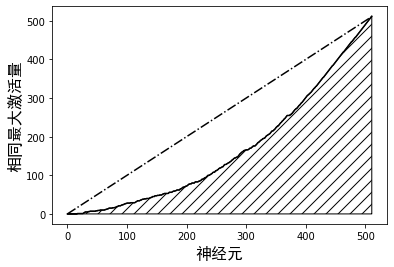

In [17]:
plt.plot([x for x in range(len(stat))],stat, 'k')
plt.plot([x for x in range(len(stat))],[x for x in range(len(stat))], 'k-.')
plt.fill_between([x for x in range(len(stat))], [0 for _ in range(len(stat))],  stat, hatch='//', edgecolor='k', fc='w')
plt.xlabel('神经元',FontProperties=my_font,fontsize=16)
plt.ylabel('相同最大激活量',FontProperties=my_font,fontsize=16)
# plt.savefig('samemax-cifar-resnet.png')
plt.savefig('samemax-cifar-preact.png')

In [18]:
neuron_num = 512
TCM = (2*sum(stat)-neuron_num)/(neuron_num*neuron_num)
print(TCM)

0.6450347900390625


In [19]:
import copy
new_params = copy.deepcopy(param_values)

In [20]:
n_out = 10

In [21]:
%%time
mal_pred = []
network.eval()
for neurons in range(neroun_num+1):
    new_params = copy.deepcopy(param_values)
    new_params['linear.weight'][:,seq_sort_clean[:neurons]] = torch.from_numpy(np.zeros([n_out, neurons])).float().cuda()
    network.load_state_dict(new_params)

    out_list = []
    for i, batch in enumerate(mal_loader):
        inputs, _ = batch
        outputs = network(inputs.to('cuda')).max(1)[1].cpu().data.numpy()
        out_list.extend(list(outputs))
    np_out_list = np.array(out_list)
    ok = np.sum(np.equal(np_out_list, y_mal))
    print(neurons, ":", ok, "\t", end="")
    mal_pred.append(ok)

0 : 8191 	1 : 8191 	2 : 8191 	3 : 8192 	4 : 8192 	5 : 8192 	6 : 8192 	7 : 8191 	8 : 8192 	9 : 8192 	10 : 8191 	11 : 8191 	12 : 8191 	13 : 8192 	14 : 8192 	15 : 8192 	16 : 8192 	17 : 8192 	18 : 8192 	19 : 8192 	20 : 8192 	21 : 8192 	22 : 8192 	23 : 8192 	24 : 8192 	25 : 8192 	26 : 8192 	27 : 8192 	28 : 8192 	29 : 8192 	30 : 8192 	31 : 8192 	32 : 8192 	33 : 8192 	34 : 8192 	35 : 8192 	36 : 8192 	37 : 8192 	38 : 8192 	39 : 8192 	40 : 8192 	41 : 8192 	42 : 8192 	43 : 8192 	44 : 8192 	45 : 8192 	46 : 8192 	47 : 8192 	48 : 8192 	49 : 8192 	50 : 8192 	51 : 8192 	52 : 8192 	53 : 8192 	54 : 8192 	55 : 8192 	56 : 8192 	57 : 8192 	58 : 8192 	59 : 8192 	60 : 8192 	61 : 8192 	62 : 8192 	63 : 8192 	64 : 8192 	65 : 8192 	66 : 8192 	67 : 8192 	68 : 8192 	69 : 8192 	70 : 8192 	71 : 8192 	72 : 8192 	73 : 8192 	74 : 8192 	75 : 8192 	76 : 8192 	77 : 8192 	78 : 8192 	79 : 8192 	80 : 8192 	81 : 8192 	82 : 8192 	83 : 8192 	84 : 8192 	85 : 8192 	86 : 8192 	87 : 8191 	88 : 8191 	89 : 8191 	90 : 8188 	91 : 8188

In [22]:
%%time
clean_train_pred = []
for neurons in range(neroun_num+1):
    new_params = copy.deepcopy(param_values)
    new_params['linear.weight'][:,seq_sort_clean[:neurons]] = torch.from_numpy(np.zeros([n_out, neurons])).float().cuda()
    network.load_state_dict(new_params)

    out_list = []
    with torch.no_grad():
        for i,batch in enumerate(train_loader):
            inputs, _ = batch
            network.eval()
            outputs = network(inputs.to('cuda')).max(1)[1].cpu().data.numpy()
            out_list.extend(list(outputs))
    np_out_list = np.array(out_list)
    ok = np.sum(np.equal(np_out_list, y_train))
    print(neurons, ':', ok, "\t", end="")
    clean_train_pred.append(ok)

0 : 50000 	1 : 50000 	2 : 50000 	3 : 50000 	4 : 50000 	5 : 50000 	6 : 50000 	7 : 50000 	8 : 50000 	9 : 50000 	10 : 50000 	11 : 50000 	12 : 50000 	13 : 50000 	14 : 50000 	15 : 50000 	16 : 50000 	17 : 50000 	18 : 50000 	19 : 50000 	20 : 50000 	21 : 50000 	22 : 50000 	23 : 50000 	24 : 50000 	25 : 50000 	26 : 50000 	27 : 50000 	28 : 50000 	29 : 50000 	30 : 50000 	31 : 50000 	32 : 50000 	33 : 50000 	34 : 50000 	35 : 50000 	36 : 50000 	37 : 50000 	38 : 50000 	39 : 50000 	40 : 50000 	41 : 50000 	42 : 50000 	43 : 50000 	44 : 50000 	45 : 50000 	46 : 50000 	47 : 50000 	48 : 50000 	49 : 50000 	50 : 50000 	51 : 50000 	52 : 50000 	53 : 50000 	54 : 50000 	55 : 50000 	56 : 50000 	57 : 50000 	58 : 50000 	59 : 50000 	60 : 50000 	61 : 50000 	62 : 50000 	63 : 50000 	64 : 50000 	65 : 50000 	66 : 50000 	67 : 50000 	68 : 50000 	69 : 50000 	70 : 50000 	71 : 50000 	72 : 50000 	73 : 50000 	74 : 50000 	75 : 50000 	76 : 50000 	77 : 50000 	78 : 50000 	79 : 50000 	80 : 50000 	81 : 50000 	82 : 50000 	83 : 50000 	84

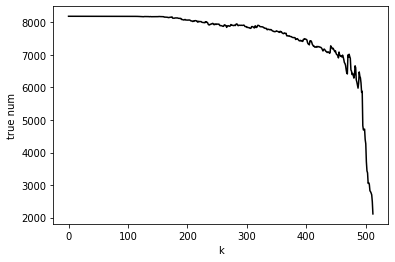

In [23]:
import pandas as pd
df_mal = pd.DataFrame(mal_pred)
df_mal.columns = ['mal']
#plt.plot(arr)
plt.plot([x for x in range(len(df_mal))],df_mal['mal'], "-k")
plt.xlabel('k')
plt.ylabel('true num') 
# plt.savefig('prune-mal-1.png')
plt.show()

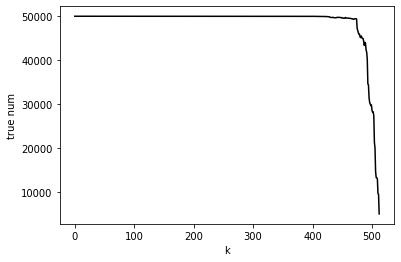

In [24]:
df_train_clean = pd.DataFrame(clean_train_pred)
df_train_clean.columns = ['train_clean']
#plt.plot(arr)
plt.plot([x for x in range(len(df_train_clean))],df_train_clean['train_clean'], "-k")
plt.xlabel('k')
plt.ylabel('true num')
# plt.savefig('prune-clean.png')
plt.show()

In [26]:
clean_test_pred = []
for neurons in range(neroun_num+1):
    new_params = copy.deepcopy(param_values)
    new_params['linear.weight'][:,seq_sort_clean[:neurons]] = torch.from_numpy(np.zeros([n_out, neurons])).float().cuda()
    network.load_state_dict(new_params)

    out_list = []
    with torch.no_grad():
        for i,batch in enumerate(test_loader):
            inputs, _ = batch
            network.eval()
            outputs = network(inputs.to('cuda')).max(1)[1].cpu().data.numpy()
            out_list.extend(list(outputs))
    np_out_list = np.array(out_list)
    ok = np.sum(np.equal(np_out_list, y_test))
    print(neurons, ':', ok, "\t", end="")
    clean_test_pred.append(ok)

0 : 9446 	1 : 9446 	2 : 9446 	3 : 9443 	4 : 9442 	5 : 9440 	6 : 9442 	7 : 9449 	8 : 9452 	9 : 9452 	10 : 9452 	11 : 9446 	12 : 9448 	13 : 9445 	14 : 9445 	15 : 9445 	16 : 9440 	17 : 9442 	18 : 9445 	19 : 9443 	20 : 9443 	21 : 9442 	22 : 9442 	23 : 9439 	24 : 9439 	25 : 9443 	26 : 9441 	27 : 9443 	28 : 9443 	29 : 9443 	30 : 9443 	31 : 9446 	32 : 9449 	33 : 9450 	34 : 9450 	35 : 9449 	36 : 9447 	37 : 9446 	38 : 9447 	39 : 9446 	40 : 9447 	41 : 9446 	42 : 9448 	43 : 9446 	44 : 9447 	45 : 9447 	46 : 9447 	47 : 9445 	48 : 9447 	49 : 9446 	50 : 9444 	51 : 9444 	52 : 9445 	53 : 9442 	54 : 9441 	55 : 9442 	56 : 9444 	57 : 9444 	58 : 9441 	59 : 9442 	60 : 9437 	61 : 9441 	62 : 9441 	63 : 9440 	64 : 9440 	65 : 9442 	66 : 9440 	67 : 9440 	68 : 9441 	69 : 9441 	70 : 9440 	71 : 9442 	72 : 9440 	73 : 9443 	74 : 9444 	75 : 9444 	76 : 9441 	77 : 9436 	78 : 9437 	79 : 9440 	80 : 9442 	81 : 9440 	82 : 9447 	83 : 9450 	84 : 9447 	85 : 9443 	86 : 9444 	87 : 9440 	88 : 9438 	89 : 9439 	90 : 9438 	91 : 9441

In [27]:
df_test = pd.DataFrame(clean_test_pred)

In [28]:
df = df_train_clean.copy()
df['mal'] = df_mal.copy()
df['test_clean'] = df_test.copy()

In [29]:
df['train_clean'] = df['train_clean']/len(X_train)
df['mal'] = df['mal']/len(X_mal)
df['test_clean'] = df['test_clean']/len(X_test)

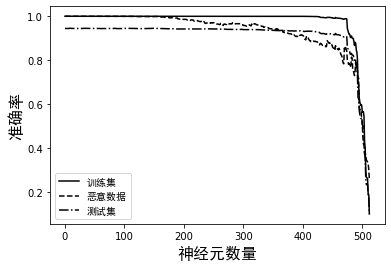

In [30]:
plt.plot([x for x in range(len(df['train_clean']))],df['train_clean'], "-k", label='训练集')
plt.plot([x for x in range(len(df['mal']))],df['mal'], "--k", label='恶意数据')
plt.plot([x for x in range(len(df['test_clean']))],df['test_clean'], "-.k", label='测试集')
plt.xlabel('神经元数量',FontProperties=my_font,fontsize=16)
plt.ylabel('准确率',FontProperties=my_font,fontsize=16)
plt.legend(prop=my_font,fontsize=16)
plt.savefig('prune-accuracy-cifar-preact.png')

In [31]:
torch.save(new_params, 'prune-model-cifar-preact.ckpt')